# Introduction

In this unit, we will use an approximation method called probability density approximation () to implement  
[Simple Retrieval Model 1](../../../Tutorial_Models/Unit1/Simple_Retrieval_1/Simple_Retrieval_Model_1.ipynb) from Unit 1. Probability density approximation is a general method that can be used even when a analytic likelihood function cannot be derived. 


# Likelihood Approximation Methods

There are several likelihood approximation methods that can be used, particularly when a likelihood is intractable or unknown. Each method involves simulating the model many times and comparing the simulated data to the empirical data with a cost function, which quantifies the degree of fit or similarity. 

## Moments

One approach is to compare simulated and empirical data in terms of moments (e.g. mean, variance, kurtosis etc..)(Turner & Van Zandt, 2012). This approach is often more computationally efficient, but only works effectively if sufficiency can be achieved. A set of estimators are said to be sufficient if they jointly contain all of the information available in the data for parameter estimation. In other words, sufficient statistics do not lead to a loss of information. For example, the sample mean and variance are sufficient estimators for the normal distribution. Outside of simple cases, such as the normal distribution, proving sufficiency can be difficult or impossible. Thus, in practice, using moments is not always feasible.


## Probability Density Approximation

An alternative is to use probability density approximation (PDA) in which the entire distribution of simulated data are used to approximate the likelihood function (Turner, & Sederberg, 2014). Sufficiency is garunteed with probability density approximation because all of the data are used. Thus, no loss of information occurs aside from approximation error. The cost of sufficiency is often paid in terms of more simulations. However, this is often the only feasible course of action. 

### Example 

PDA involves generating a distribution of predictions and transforming it into a probability mass if the data are discrete or a probability density if the data are continuous. In the introduction, we hinted at the PDA method. Suppose we wanted the approximate the likelihood function for a coin flip to calculate the probability of $H$ heads out of $n$ flips. Lets load the required packages first. 


In [1]:
# set the working directory to the directory in which this file is contained
cd(@__DIR__)
# load the package manager
using Pkg
# activate the project environment
Pkg.activate("../../../")
# load the required packages
using DifferentialEvolutionMCMC, StatsPlots, Revise, ACTRModels, MCMCChains
# load all model functions
include("Simple_Retrieval_1_PDA.jl")
# seed random number generator
Random.seed!(2050);

  Activating environment at `~/.julia/dev/ACTRTutorial/Project.toml`
┌ Info: Precompiling DifferentialEvolutionMCMC [607db5a9-722a-4af8-9a06-1810c0fe385b]
└ @ Base loading.jl:1342
┌ Info: Precompiling StatsPlots [f3b207a7-027a-5e70-b257-86293d7955fd]
└ @ Base loading.jl:1342
┌ Info: Precompiling Revise [295af30f-e4ad-537b-8983-00126c2a3abe]
└ @ Base loading.jl:1342
┌ Info: Precompiling ACTRModels [c095b0ea-a6ca-5cbd-afed-dbab2e976880]
└ @ Base loading.jl:1342


The function `simulate_coin` simulates $n$ coin flips with parameter $\theta$ and counts the number of simulated heads $h$. The vector `sim_data` tracks the counts for each outcome where `sim_data[1]` contains the count of outcomes in which zero heads were simulated, `sim_data[2]` contains the count of outcomes in which 1 head was simulated and so forth. `simulate_coin` is annoted below:

In [2]:
function simulate_coin!(θ, n, sim_data)
    # number of successes
    h = 0
    # simulate n trials
    for t ∈ 1:n
        # increment h if successfull
        h += rand() ≤ θ ? 1 : 0
    end
    # update distribution count vector
    sim_data[h + 1] += 1
    return nothing
end

simulate_coin! (generic function with 1 method)

In the following two code blocks, we will compare the approximation with 1,000 simulations to the analytic solution, which is:

\begin{align}
\mathcal{L}(\theta; H=h, n)  = {n \choose h} \theta^h (1-\theta)^{n-h}
\end{align}


You will notice that there is some approximation error. Each time that you run the two blocks, the approximation is slightly different. If you increase `n_sim`, the approximation will be closer, but will run slower. This tradeoff is a general property of approximation based likelihood methods. 

In [3]:
# the number of simulations
n_sim = 1_000
# true probability of heads
θ = 0.5
# number of trials per simulation
n = 10
# initialize counts (0-10 heads) at zero
sim_data = fill(0, n+1)
# execute the simulation n_sim times
map(_ -> simulate_coin!(θ, n, sim_data), 1:n_sim);
# relative frequency of each outcome
sim_probs =  sim_data/n_sim

11-element Vector{Float64}:
 0.0
 0.014
 0.035
 0.132
 0.205
 0.242
 0.218
 0.1
 0.042
 0.012
 0.0

┌ Info: Precompiling GR_jll [d2c73de3-f751-5644-a686-071e5b155ba9]
└ @ Base loading.jl:1342


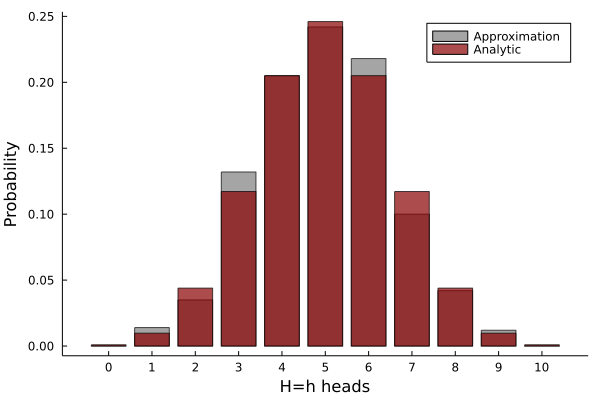

In [4]:
# Plot the results
bar(0:n, sim_probs, xticks=0:n, color=:grey, alpha=0.7, grid=false, label="Approximation", xlabel="H=h heads", ylabel="Probability")
prob_mass = map(h -> pdf(Binomial(n, θ), h), 0:n)
bar!(0:n, prob_mass, xticks=0:n, color=:darkred, alpha=0.7, label="Analytic")

Let's express the approximation more formally. To begin, define $X = \{X_1,X_1,\dots, X_{n_s}\}$ as a set of $n_s$ simulated binomially distributed data. Now we can use the relative frequency of $h$ in $X$ to approximate the likelihood:
\begin{equation}
 \textrm{Pr}(H=h) \approx \frac{1}{n_s} \sum_{i=1}^{n_s} I(x_i, h)
\end{equation}
where indicator function $I(x_i,h)$ yields 1 if the inputs are equal and 0 otherwise. As $n_s$ increases, the approximation becomes more accurate and converges on the analytic likelihood in the limit.


# Task and Model

We will briefly outline the task and model here. Please review the original description of the [model](../../../Tutorial_Models/Unit1/Simple_Retrieval_1/Simple_Retrieval_Model_1.ipynb) and task if necessary. The task is a paired associates task in which a series of pairs are learned. Later the model must use the first member of the pair as a cue for the second member. If the activation of the chunk is above the retrieval threshold, the correct answer will be given. Otherwise a retrieval failure occurs, and the answer is marked as incorrect. The probability of a correct response can be expressed as:

\begin{align}
 \theta_r = \rm Pr(\mathbf{c}_m \mid \tau; \mathbf{r}_i)  \approx \frac{e^{\frac{\mu_m}{\sigma}}}{e^{\frac{\tau}{\sigma}} + e^{\frac{\mu_m}{\sigma}}}
\end{align}

Thus, the probability of a correct response depends on the retrieval threshold $\tau$ and the retrieval request $\mathbf{r}_i$. 

## Generate Data

The `simulate` function will simulate `n_trials` of the model. `simulate` accepts the following arguments:

- parms: a `NamedTuple` of fixed parameters
- n_trials: the number of simulated trials
- $\tau$: a keyword argument for the retrieval threshold parameter


The function `simulate` performs the following actions:

1. It creates an ACT-R object containing a declarative memory object and parameters
2. It computes a retrieval probability $\theta$ using the function `retrieval_prob` 
3. It generates a random number of correct trials from a binomial distribution using $\theta$ and n_trials as inputs

The function `get_retrieval_prob` creates the model object and returns the retrieval probability. It accepts the arguments 

- parms: a `NamedTuple` of fixed parameters
- n_trials: the number of simulated trials
- $\tau$: a keyword argument for the retrieval threshold parameter

As will become appearent later, the reason for dividing the simulation process into two functions is to improve the computational efficiency of the simulation process during parameter estimation. 

In [5]:
function simulate(parms, n_trials; τ)
    θ = get_retrieval_prob(parms, n_trials; τ)
    # Simulate n_trials
    data = rand(Binomial(n_trials, θ))
    return data
end

function get_retrieval_prob(parms, n_trials; τ)
    # Create a chunk object
    chunk = Chunk()
    # Create a declarative memory object
    memory = Declarative(;memory=[chunk])
    # Create an ACTR object
    actr = ACTR(;declarative=memory, parms..., τ)
    # Compute the retrieval probability of the chunk
    θ,_ = retrieval_prob(actr, chunk)
    return θ
end

get_retrieval_prob (generic function with 1 method)

In the following code, we will generate 50 simulated trials. The `NamedTuple` parms contains our fixed parameters and $\tau$, which will be estimated, is set to .5 and passed separately. 

In [6]:
# The number of trials
n_trials = 50
# True value of retrieval threshold
τ = 0.5
# Fixed parameters
parms = (blc = 1.5,s = 0.4)
# Simulate the number of correct retrievals
data = simulate(parms, n_trials; τ)

42

## Define Approximate Likelihood Function

The function for the approximate likelihood will be similar to the coinflip example in the section for Probabiltiy Density Approximation. Rather than simulating the flip of a coin, it will simulate memory retrieval as specified in the simple ACT-R model. In the present example, we simulate `n_trial`=50 trials and observed $k$ successful memory retrievals. To approximate the log likelihood, we will simulate `n_trial`=50 trials `n_sim`=10,000 times and count the number of times in which $k$ memories were retrieved successfully. The relative frequency provides an approximate likelihood. We will define a function called `loglike` to perform this function and pass it to the model object later. `loglike` requires the following parameters: 

- k: the number of retrievals
- τ: retrieval threshold parameter
- n_trials: the number of simulated trials
- parms: a `NamedTuple` of fixed parameters
- n_sim: he number model simulations. Default 10,000

You may have noticed that the indicator function `counter` uses `rand(Binomial(n_trials, θ))` rather than `simulate(parms, n_trials; τ)`. Although both functions could be used, `simulate` is less efficient because it re-generates the model object and re-computes the retrieval probability each time. Recomputing these quantities is unecessary because they are all the same. This is the reason the simulation process was divided into two functions:  `get_retrieval_prob` and `simulate`. This makes the code run about 40X faster. More details can be found int annotated function below.

In [7]:
function loglike(k, τ; n_trials, parms, n_sim = 10^4)
    # return the retrieval probability 
    θ = get_retrieval_prob(parms, n_trials; τ)
    # indicator function that returns 1 if simulation returns k retrievals
    counter(_) = rand(Binomial(n_trials, θ)) == k ? 1 : 0
    # repeat simulation n_sim times while counting the number of cases in which 
    # k retrievals were found
    cnt = mapreduce(counter, +, 1:n_sim)
    # return the approximate log probability of k retrievals
    return log(cnt / n_sim)
end

loglike (generic function with 1 method)

## Define Model

In mathematical notation, we can summarize the model definition as follows:

\begin{align*}
\tau \sim \rm Normal(.5,.5) \\
\theta_{r} = \rm Pr(\mathbf{c}_m \mid \tau; \mathbf{r}_i)  \\
n_{r} \sim \rm Binomial(n_{t},\theta_r)
\end{align*}


In the next code block, we will set the prior distribution for $\tau$, define the lower and upper bounds of $\tau$, create a model object containing the prior, the likelihood function, the data, and other inputs, and finally create a sampler object for differential evolution MCMC. 

In [8]:
# prior on τ
priors = (
    τ = (Normal(.5, .5),),
)
# lower and upper bounds for τ
bounds = ((-Inf,Inf),)

# generate model object
model = DEModel(; priors, model=loglike, data, n_trials, parms)

# generate sampler object
de = DE(;bounds, burnin=1000, priors);

## Estimate Parameters

We will use Differential Evolution MCMCM (Turner, Sederberg, Brown, & Steyvers, 2013) to estimate the posterior distribution. The code sampler runs four groups of three chains for 2,000 iterations and removes the first 1,000 burnin samples. 

In [9]:
n_iter = 2000
# perform parameter estimation 
chain = sample(model, de, MCMCThreads(), n_iter, progress=true)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:09


Chains MCMC chain (1000×3×12 Array{Float64, 3}):

Iterations        = 1:1:1000
Number of chains  = 12
Samples per chain = 1000
parameters        = τ
internals         = acceptance, lp

Summary Statistics
  parameters      mean       std   naive_se      mcse         ess      rhat 
      Symbol   Float64   Float64    Float64   Float64     Float64   Float64 

           τ    0.5373    0.2008     0.0018    0.0062   1197.1586    1.0108

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

           τ    0.1196    0.4058    0.5432    0.6785    0.9102


┌ Warning: timestamp of type Missing unknown
└ @ MCMCChains /home/dfish/.julia/packages/MCMCChains/pPqxj/src/chains.jl:364
┌ Warning: timestamp of type Missing unknown
└ @ MCMCChains /home/dfish/.julia/packages/MCMCChains/pPqxj/src/chains.jl:364


## Results

### Diagnostics

The code below shows the trace, autocorrelation and posterior distribution. The trace show that the chains are noisy and superimposed, suggesting good mixing. This is confirmed with $r^\hat \approx 1.02$. Autocorrelation is greater than what is typically observed with the NUTS algorithm, but is acceptable for DEMCMC. As expected, the posterior distribution is centered near the true value of $\tau = .5$


In [13]:
pyplot()
font_size = 12
ch = group(chain, :τ)
p1 = plot(ch, xaxis=font(font_size), yaxis=font(font_size), seriestype=(:traceplot),
  grid=false, size=(250,100), titlefont=font(font_size))
p2 = plot(ch, xaxis=font(font_size), yaxis=font(font_size), seriestype=(:autocorplot),
  grid=false, size=(250,100), titlefont=font(font_size))
p3 = plot(ch, xaxis=font(font_size), yaxis=font(font_size), seriestype=(:mixeddensity),
  grid=false, size=(250,100), titlefont=font(font_size))
pcτ = plot(p1, p2, p3, layout=(3,1), size=(600,600))

MethodError: MethodError: no method matching _show(::Base64.Base64EncodePipe, ::MIME{Symbol("image/png")}, ::Plots.Plot{Plots.PyPlotBackend})
[0mClosest candidates are:
[0m  _show(::IO, [91m::MIME{Symbol("text/html")}[39m, ::Plots.Plot) at /home/dfish/.julia/packages/Plots/FCM0H/src/output.jl:163
[0m  _show(::IO, ::MIME{Symbol("image/png")}, [91m::Plots.Plot{Plots.GRBackend}[39m) at /home/dfish/.julia/packages/Plots/FCM0H/src/backends/gr.jl:2162
[0m  _show(::IO, [91m::MIME{Symbol("application/vnd.plotly.v1+json")}[39m, [91m::Plots.Plot{Plots.PlotlyBackend}[39m) at /home/dfish/.julia/packages/Plots/FCM0H/src/backends/plotly.jl:1118
[0m  ...


signal (15): Terminated
in expression starting at /home/dfish/.julia/packages/IJulia/e8kqU/src/kernel.jl:53
pthread_cond_wait at /lib/x86_64-linux-gnu/libpthread.so.0 (unknown line)
uv_cond_wait at /workspace/srcdir/libuv/src/unix/thread.c:847
jl_task_get_next at /buildworker/worker/package_linux64/build/src/partr.c:508
poptask at ./task.jl:760
wait at ./task.jl:768 [inlined]
task_done_hook at ./task.jl:494
_jl_invoke at /buildworker/worker/package_linux64/build/src/gf.c:2237 [inlined]
jl_apply_generic at /buildworker/worker/package_linux64/build/src/gf.c:2419
jl_apply at /buildworker/worker/package_linux64/build/src/julia.h:1703 [inlined]
jl_finish_task at /buildworker/worker/package_linux64/build/src/task.c:208
start_task at /buildworker/worker/package_linux64/build/src/task.c:850
unknown function (ip: (nil))
unknown function (ip: (nil))
pthread_cond_wait at /lib/x86_64-linux-gnu/libpthread.so.0 (unknown line)
uv_cond_wait at /workspace/srcdir/libuv/src/unix/thread.c:847
jl_task_get

Sometimes pooling the chains together can give us a clearer picture of the posterior distribution. This can be achieved with the function `pooleddensity` as follows:

In [11]:
pooleddensity(ch, grid=false, color=:black, size=(600,300))

LoadError: UndefVarError: ch not defined

### Posterior Predictive Distribution

In the following code block, we generate a posterior predictive distribution. A posterior predictive distribution is a mixture of predictions weighted by the posterior distribution of the parameter (e.g. $\tau$). In the current case, the posterior predictive distribution is a mixture of binomial distributions and has a known form called a Beta-Binomial distribution. Each component binomial distribution is weighted according to the posterior probability of its $\theta_r$ parameter. 

The basic algorithm for sampling from the posterior predictive uses the following steps:

1. On repetition $i$, sample a parameter value $\theta_i$ from the posterior distribution
2. Simulate data from the model using parameter $\theta_i$
3. Repeat steps 1 and 2 many times

In the code block below, function `posterior_predictive` accepts the data simulation function `simulate`, the chain object, and the number of simulations (e.g. 1000). Visual inspection of the histogram indicates 40 to 45 retrievals out of 50 attempts is a likely outcome. 

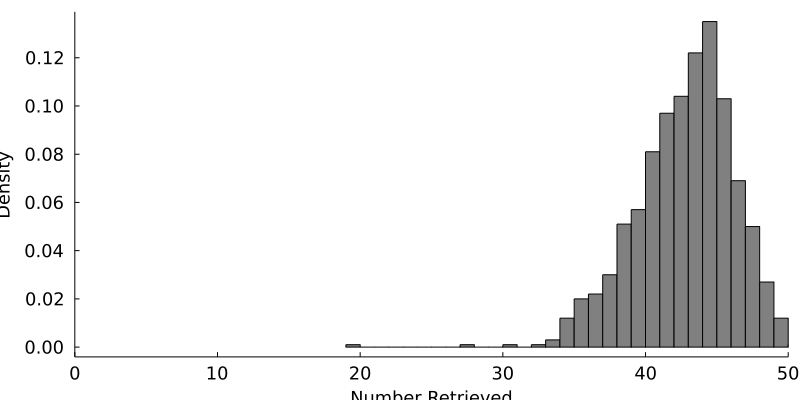

In [12]:
preds = posterior_predictive(x -> simulate(parms, n_trials; x...), chain, 1000)
p4 = histogram(preds, xlabel="Number Retrieved", ylabel="Density", xaxis=font(12), yaxis=font(12),
    xlims=(0,50), grid=false, norm=true, color=:grey, leg=false, size=(800,400), titlefont=font(12),
    bar_width=1)

# References

Turner, B. M., & Van Zandt, T. (2012). A tutorial on approximate Bayesian computation. Journal of Mathematical Psychology, 56(2), 69-85.

Turner, B. M., & Sederberg, P. B. (2014). A generalized, likelihood-free method for posterior estimation. Psychonomic bulletin & review, 21(2), 227-250.

Turner, B. M., Sederberg, P. B., Brown, S. D., & Steyvers, M. (2013). A method for efficiently sampling from distributions with correlated dimensions. Psychological methods, 18(3), 368.

Weaver, R. (2008). Parameters, predictions, and evidence in computational modeling: A statistical view informed by ACT–R. Cognitive Science, 32(8), 1349-1375.